In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
data = pd.read_csv(r'C:\Users\Admin\Downloads\References\23-24-1\thesis\Movie-Recommendation-System\data\train_set.csv', )
trainset, validset = train_test_split(data, test_size=0.2, random_state = 42, stratify=data['userId'])

trainset

,userId,movieId,rating,timestamp
27282,544,4963,4.5,1435790757
28513,99,5952,4.0,1044786919
956,396,29,4.0,839256240
44694,150,435,2.5,1114309597
26806,41,6333,4.0,1109812953
...,...,...,...,...
20943,55,79,3.0,855927172
71762,572,60072,3.0,1436779892
14928,134,1584,3.5,1361245898
1642,533,3196,4.0,965316395


In [3]:
import numpy as np

from surprise import Dataset, Reader
from surprise import NMF, SVD
# from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.dataset import DatasetAutoFolds

from collections import defaultdict
from surprise import SVD, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering, Reader


Metrics sử dụng trong bài để so sánh các thuật toán là RMSE, MAE, precision, recall, f-measure

In [4]:
# Tính precision, recall, f-measure
def precision_recall_at_k(test_df, threshold):
    """Return recall and precision, F-1 scrore for collaborative + hybrid

    Args:
        test_df: prediction dataframe, with 4 columns: userId, movieId, true_rating, pred_rating
        threshold: if rating > threshold, movie is believed to be relevant

    Returns:
    Recall: Proportion of relevant items that are recommended, dict-like
    Precision: Proportion of recommended items that are relevant, dict-like
        Movie is relevant if true_rating > threshold
        Movie is recommend when pred_rating > threshold
    """
    recalls = dict()
    precisions = dict()

    for userId, group in test_df.groupby('userId'):

        filter_rel = group[group['rating'] > threshold]
        filter_rec = group[group['pred_rating'] > threshold]
        filter_rel_rec = group[(group['pred_rating'] > threshold) & \
                               (group['rating'] > threshold)]

        # Number of relevant items
        n_rel = len(filter_rel)

        # Number of recommended items in top k
        n_rec = len(filter_rec)

        # Number of relevant and recommended items in top k
        n_rel_rec = len(filter_rel_rec)

        recalls[userId] = n_rel_rec/n_rel if n_rel != 0 else 1
        precisions[userId] = n_rel_rec/n_rec if n_rec != 0 else 1

    precision = sum(prec for prec in precisions.values())/len(precisions)
    recall = sum(rec for rec in recalls.values())/len(recalls)
    fmeasure = (2*precision*recall)/(precision + recall)

    return recall, precision, fmeasure
    

Tạo class CollaborativeFiltering, trong đó: \
input thuật toán, trainset, testset -> trả ra predictions trên tập test, các metrics đánh giá

In [5]:
class CollaborativeFiltering:
    def __init__(self, algorithm=None):
        self.trainset = None
        self.testset = None
        self.algorithm = algorithm
        self.predictions = None
        self.test_df = None
        
    def load_data(self, trainset: pd.DataFrame, testset: pd.DataFrame):
        reader = Reader()
  
        train = Dataset.load_from_df(trainset[['userId', 'movieId', 'rating']], reader)
        test = Dataset.load_from_df(testset[['userId', 'movieId', 'rating']], reader)
        
        self.trainset = train.build_full_trainset()
        full_testset = test.build_full_trainset()
        self.testset = full_testset.build_testset()
        
    def fit_predict(self):
        # Fit
        self.algorithm.fit(self.trainset)
        # Predict
        predictions_test = self.algorithm.test(self.testset)
        self.predictions = predictions_test

        # Tính rmse, mae
        rmse = accuracy.rmse(predictions_test)
        mae = accuracy.mae(predictions_test)

        # Tính precision, recall, f-measure với threshold rating = 3.75
        test_df = pd.DataFrame(self.predictions).drop(columns='details')
        test_df.columns = ['userId', 'movieId', 'rating', 'pred_rating']
        self.test_df = test_df
        pre, recall, f_measure = precision_recall_at_k(test_df, 3.75)

        # trả ra 1 tuple gồm 5 metrics đã tính
        return rmse, mae, pre, recall, f_measure



#### Đánh giá các thuật toán
Test các thuật toán khác nhau: SVD, NMF, KNN,... 
- Thấy rằng SVD, SVDpp, KNN Baseline, Baseline cho kết quả RMSE và precision tốt nhất so với các phương pháp còn lại \
RMSE khoảng 0.89 - 0,91 \
MAE khoảng 0.7 \
precision khoảng 0.52 - 0.57 
- Đặc biệt, KNN Baseline tuy có RMSE cao hơn 3 thuật toán còn lại một chút (cao hơn khoảng 0.01) nhưng precision cao hơn khá nhiều (=0.6011) \
- Nhìn chung các thuật toán KNN cho precision xấp xỉ 0.6, cao hơn các thuật toán còn lại. 


? Nên chọn thuật toán dựa theo RMSE hay precision?

In [6]:
svd = CollaborativeFiltering(SVD())
svd.load_data(trainset, validset)
svd.fit_predict()
# rmse, mae, precision, recall, f-measure

RMSE: 0.9026
MAE:  0.6989


(0.9025902414274269,
 0.6989158012542752,
 0.5460170503662098,
 0.7886174059904802,
 0.6452681448998847)

In [7]:
# Chọn SVD

In [8]:
nmf = CollaborativeFiltering(NMF())
nmf.load_data(trainset, validset)
nmf.fit_predict()



RMSE: 0.9655
MAE:  0.7429


(0.9655484443234076,
 0.74289373601473,
 0.5473679564331796,
 0.7550963592034252,
 0.6346669863969316)

In [9]:
svd_pp = CollaborativeFiltering(SVDpp())
svd_pp.load_data(trainset, validset)
svd_pp.fit_predict()

RMSE: 0.8913
MAE:  0.6869


(0.8913159056808497,
 0.68689085465925,
 0.557688025517613,
 0.7883979008338885,
 0.6532719197652009)

In [10]:
# Chọn SVD_pp

In [11]:
base = CollaborativeFiltering(BaselineOnly())
base.load_data(trainset, validset)
base.fit_predict()

Estimating biases using als...
RMSE: 0.8959
MAE:  0.6948


(0.8959359082434771,
 0.6947684945619227,
 0.5242606261989056,
 0.7954302358494028,
 0.6319855134810897)

In [12]:
# Chọn Baseline only

In [13]:
slope_one = CollaborativeFiltering(SlopeOne())
slope_one.load_data(trainset, validset)
slope_one.fit_predict()

RMSE: 0.9401
MAE:  0.7225


(0.9400987538992951,
 0.7224915394597742,
 0.5579230180763148,
 0.7641522126082897,
 0.6449528723223139)

In [14]:
from surprise.prediction_algorithms import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore

In [15]:
knn_base = CollaborativeFiltering(KNNBaseline())
knn_base.load_data(trainset, validset)
knn_base.fit_predict()

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9064
MAE:  0.6960


(0.9064242777503783,
 0.6959879814186629,
 0.6011469016679707,
 0.7557408715283147,
 0.6696372277169577)

In [16]:
# KNN baseline ổn

In [17]:
KNN_basic = CollaborativeFiltering(KNNBasic())
KNN_basic.load_data(trainset, validset)
KNN_basic.fit_predict()

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9822
MAE:  0.7561


(0.9821644552243276,
 0.7560629093594452,
 0.5984823503523305,
 0.7297152062764107,
 0.6576155325095433)

In [18]:
KNN_means = CollaborativeFiltering(KNNWithMeans())
KNN_means.load_data(trainset, validset)
KNN_means.fit_predict()

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9279
MAE:  0.7117


(0.9278605725076455,
 0.7116961796504687,
 0.5771583922079696,
 0.7760328842089919,
 0.6619816422945439)

In [19]:
KNN_Z = CollaborativeFiltering(KNNWithZScore())
KNN_Z.load_data(trainset, validset)
KNN_Z.fit_predict()

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9270
MAE:  0.7068


(0.9270370628606168,
 0.7068406602644297,
 0.5907476145784287,
 0.7689852586590943,
 0.668184488497663)

In [20]:
df = svd.test_df
df.columns = ['userId',	'movieId',	'rating',	'svd_rating']
df['svd_pp'] = svd_pp.test_df['pred_rating']
df['base'] = base.test_df['pred_rating']
df['knn_base'] = knn_base.test_df['pred_rating']
df.head()

,userId,movieId,rating,svd_rating,svd_pp,base,knn_base
0,212,916,3.5,3.446143,3.657922,3.525547,3.867603
1,212,5459,2.0,3.141468,3.036045,2.904066,2.857219
2,212,172,2.0,2.441299,2.382775,2.382521,2.126295
3,212,2421,2.0,2.594477,2.286247,2.563658,2.292795
4,212,3988,3.0,2.912279,2.809627,2.828012,2.730163


### (Linear) Combine 
Dùng 4 thuật toán cho kết quả tốt nhất phía trên, linear combine kết quả để tạo ra rating mới, sau đó so sánh với real rating xem các metrics có cải thiện không

In [21]:
# Weight cho các thuật toán khác nhau
svd_wt = 0.25
knn_base_wt = 0.25
svdpp_wt = 0.3
base_wt = 0.2

combined_df = svd.test_df[['userId',	'movieId',	'rating']]
combined_df['pred_rating']  = svd_wt*df['svd_rating'] + svdpp_wt*df['svd_pp'] + knn_base_wt*df['knn_base'] + base_wt*df['base']

C:\Users\Admin\AppData\Local\Temp\ipykernel_5948\598306185.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['pred_rating']  = svd_wt*df['svd_rating'] + svdpp_wt*df['svd_pp'] + knn_base_wt*df['knn_base'] + base_wt*df['base']


In [22]:
combined_df

,userId,movieId,rating,pred_rating
0,212,916,3.5,3.630922
1,212,5459,2.0,2.991299
2,212,172,2.0,2.333235
3,212,2421,2.0,2.420424
4,212,3988,3.0,2.819101
...,...,...,...,...
14996,100,745,4.0,4.178960
14997,100,708,3.0,3.251880
14998,76,2087,3.5,4.019646
14999,76,3671,3.5,4.057982


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(combined_df['rating'], combined_df['pred_rating'], squared=False)

mae = mean_absolute_error(combined_df['rating'], combined_df['pred_rating'])
rmse, mae

(0.882669663887217, 0.6814708880936718)

In [24]:
precision, recall, f_measure = precision_recall_at_k(combined_df, 3.75)

precision, recall, f_measure 

(0.5574899442795901, 0.7850787888449291, 0.6519942248761645)

Có thể thấy cả RMSE, MAE đều giảm so với tất cả các thuật toán riêng lẻ -> Combine có thể cho kết quả tốt hơn một chút \
Tuy nhiên precision, recall không có sự khác biệt lớn

## Evaluate trên metric tự build

Idea: 
- Train lại model đạt kết quả tốt trên cả tập train (= tập train + valid phía trên), predict cho tập anti của train
- Chọn top n movies có đánh giá predicted cao nhất của mỗi user 
- Dùng metric tính xem có bao nhiêu movies người dùng thực sự xem trong số được đề xuất 

In [25]:
test = pd.read_csv(r'C:\Users\Admin\Downloads\References\23-24-1\thesis\Movie-Recommendation-System\data\test_set.csv')
data = pd.read_csv(r'C:\Users\Admin\Downloads\References\23-24-1\thesis\Movie-Recommendation-System\data\train_set.csv')

In [26]:
reader = Reader()

train = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)

trainset = train.build_full_trainset()
anti_train = trainset.build_anti_testset()

test_set = test[['userId', 'movieId']]

In [27]:
def top_n(predictions, n_predict):
    predict_df = pd.DataFrame(predictions).sort_values(by='est', ascending=False)
    top_n = predict_df.groupby('uid', sort=False).head(n_predict)
    top_n = top_n[['uid', 'iid']]
    top_n.columns = ['userId', 'movieId']
    return top_n

In [28]:
def check_movieId(pred_df, val_df):
    result = pred_df['movieId'].isin(val_df[val_df['userId'] == \
                                   pred_df['userId'].iloc[0]]['movieId'])
    return result.reset_index(drop=True)

def evaluate(pred_df, val_df):
    """ Proportion of movies recommended that were actually watched by users

    Args:
    pred_df: dataframe, 2 columns: userId, movieId
    val_df: dataframe, 2 columns: userId, movieId

    Returns:
    
    """
    result = pred_df.groupby('userId').apply(lambda x: check_movieId(x, val_df))
    result = result.groupby('userId').sum() / result.groupby('userId').count()

    return result.mean().mean()

In [29]:
# SVD

model = SVD()
model.fit(trainset)
svd_predictions = model.test(anti_train)

print(' n=5: metric = ', evaluate(top_n(predictions=svd_predictions, n_predict=5), test_set),
'\n n=10: metric = ', evaluate(top_n(predictions=svd_predictions, n_predict=10), test_set),
'\n n=50: metric = ', evaluate(top_n(predictions=svd_predictions, n_predict=50), test_set))


 n=5: metric =  0.07421758569299552 
 n=10: metric =  0.06154992548435172 
 n=50: metric =  0.04166915052160954


In [30]:
# SVDpp

model = SVDpp()
model.fit(trainset)
pp_predictions = model.test(anti_train)

print(' n=5: metric = ', evaluate(top_n(predictions=pp_predictions, n_predict=5), test_set),
'\n n=10: metric = ', evaluate(top_n(predictions=pp_predictions, n_predict=10), test_set),
'\n n=50: metric = ', evaluate(top_n(predictions=pp_predictions, n_predict=50), test_set))


 n=5: metric =  0.07958271236959762 
 n=10: metric =  0.06721311475409836 
 n=50: metric =  0.039701937406855445


 n=10: metric =  0.0684053651266766 


In [56]:
# baseline only

model = BaselineOnly()
model.fit(trainset)
b_predictions = model.test(anti_train)

print('n=5: metric = ', evaluate(top_n(predictions=b_predictions, n_predict=5), test_set),
'\n n=10: metric = ', evaluate(top_n(predictions=b_predictions, n_predict=10), test_set),
'\n n=50: metric = ', evaluate(top_n(predictions=b_predictions, n_predict=50), test_set))


Estimating biases using als...
n=5: metric =  0.11028315946348735 
 n=10: metric =  0.0819672131147541 
 n=50: metric =  0.056274217585692995


In [51]:
# KNN baseline

model = KNNBaseline()
model.fit(trainset)
knn_predictions = model.test(anti_train)

print('n=5: metric = ', evaluate(top_n(predictions=knn_predictions, n_predict=5), test_set),
'\n n=10: metric = ', evaluate(top_n(predictions=knn_predictions, n_predict=10), test_set),
'\n n=50: metric = ', evaluate(top_n(predictions=knn_predictions, n_predict=50), test_set))


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
n=5: metric =  0.0014903129657228018 
 n=10: metric =  0.0013412816691505216 
 n=50: metric =  0.0008941877794336811


In [55]:
## Combine
df = pd.DataFrame(svd_predictions).drop(columns='details')


df.columns = ['userId',	'movieId',	'rating',	'svd']
df['svd_pp'] = pd.DataFrame(pp_predictions)['est']
df['base'] = pd.DataFrame(b_predictions)['est']
df['knn_base'] = pd.DataFrame(knn_predictions)['est']

# Weight 
svd_wt = 0.25
knn_base_wt = 0.25
svdpp_wt = 0.3
base_wt = 0.2

# combined_df = svd.test_df[['userId',	'movieId',	'rating']]
df['pred_rating']  = svd_wt*df['svd'] + svdpp_wt*df['svd_pp'] + knn_base_wt*df['knn_base'] + base_wt*df['base']

In [56]:
df

,userId,movieId,rating,svd,svd_pp,base,knn_base,pred_rating
0,431,7173,3.544645,3.164614,3.287579,3.458780,3.014032,3.222691
1,431,1032,3.544645,3.894718,3.862493,4.047053,4.156138,3.980872
2,431,1221,3.544645,4.601537,5.000000,4.716836,4.887586,4.815648
3,431,141,3.544645,3.439073,3.887830,3.842440,4.030897,3.802329
4,431,5060,3.544645,4.025399,4.195905,4.082440,4.226371,4.138202
...,...,...,...,...,...,...,...,...
5418469,45,126006,3.544645,3.538778,3.561963,3.512441,3.615896,3.559746
5418470,45,140928,3.544645,3.245804,3.193192,3.338347,1.700766,2.862269
5418471,45,138258,3.544645,3.501522,3.473666,3.474711,3.200766,3.412614
5418472,45,1329,3.544645,3.582664,3.370627,3.449408,2.922496,3.327360


In [61]:
def top_n_combine(predictions_df, n_predict):
    predict_df = predictions_df.sort_values(by='pred_rating', ascending=False)
    top_n = predict_df.groupby('userId', sort=False).head(n_predict)
    top_n = top_n[['userId', 'movieId']]
    
    return top_n

In [62]:
top_n_combine(df, n_predict=10)

,userId,movieId
4254728,46,106920
4252672,46,926
1335882,656,1276
1641302,287,50
3910617,298,1203
...,...,...
4710907,581,1945
4710125,581,968
4708962,581,527
4712906,581,3216


In [64]:
# Combine

print('n=5: metric = ', evaluate(top_n_combine(df, n_predict=5), test_set),
'\n n=10: metric = ', evaluate(top_n_combine(df, n_predict=10), test_set),
'\n n=50: metric = ', evaluate(top_n_combine(df, n_predict=50), test_set))


n=5: metric =  0.08286140089418778 
 n=10: metric =  0.06512667660208643 
 n=50: metric =  0.038092399403874815


### EXAMPLE
#### Thử với SVDpp

In [45]:
# Cho SVDpp

def top_n_by_user(predictions, user_id, n_predict=10):
    predict_df = pd.DataFrame(predictions)
    top_n = predict_df[predict_df['uid'] == user_id].sort_values(by='est', ascending=False).head(n_predict)

    top_n = top_n[['uid', 'iid']]
    top_n.columns = ['userId', 'movieId']
    return top_n



In [46]:
rec_583 = top_n_by_user(pp_predictions, 583)
rec_583

,userId,movieId
4122253,583,926
4124083,583,3462
4124171,583,7502
4125112,583,905
4122303,583,904
4122146,583,527
4121921,583,1172
4122101,583,1254
4122052,583,969
4123312,583,968


In [47]:
rec_583['movieId'].to_list()

[926, 3462, 7502, 905, 904, 527, 1172, 1254, 969, 968]

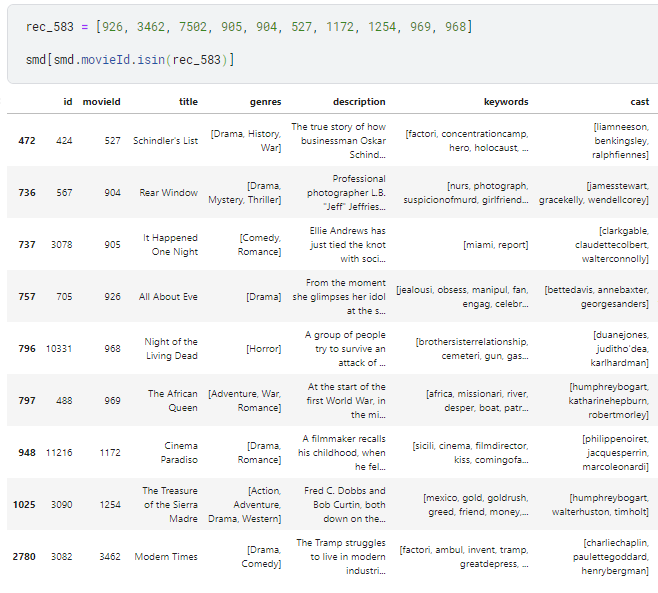

In [52]:
rec_630 = top_n_by_user(pp_predictions, 630)
rec_630

,userId,movieId
2636561,630,3462
2634100,630,318
2634530,630,969
2634732,630,926
2634541,630,922
2637591,630,905
2634006,630,1148
2636219,630,2019
2634435,630,1197
2634624,630,527


In [54]:
rec_630['movieId'].to_list()

[3462, 318, 969, 926, 922, 905, 1148, 2019, 1197, 527]

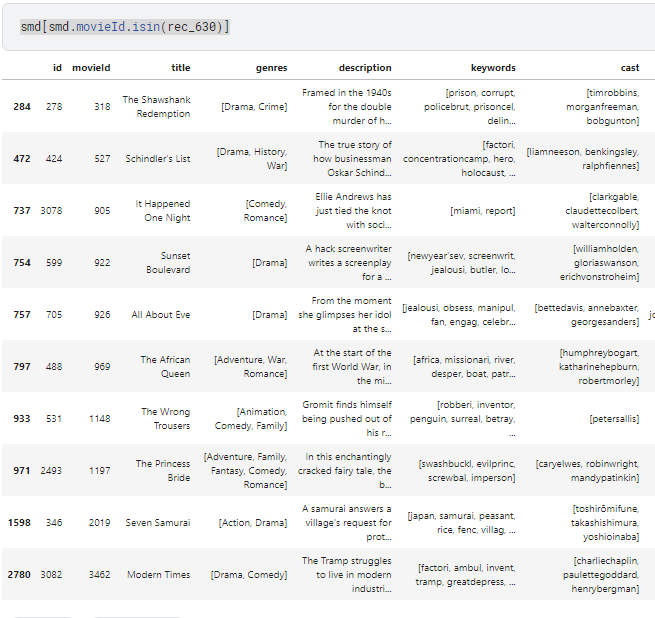

#### Thử với BaselineOnly

In [57]:
rec_583 = top_n_by_user(b_predictions, 583)
rec_583

,userId,movieId
4121776,583,858
4121502,583,1221
4122165,583,50
4122814,583,912
4122146,583,527
4121805,583,1193
4122253,583,926
4122244,583,908
4124083,583,3462
4122303,583,904


In [58]:
rec_583['movieId'].to_list()

[858, 1221, 50, 912, 527, 1193, 926, 908, 3462, 904]

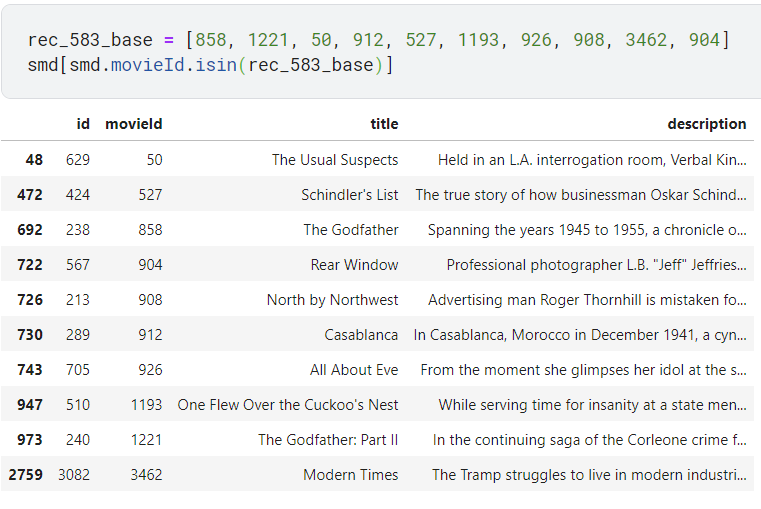

In [60]:
rec_630 = top_n_by_user(b_predictions, 630)
rec_630['movieId'].to_list()

[318, 50, 527, 1193, 926, 3462, 608, 296, 913, 1228]

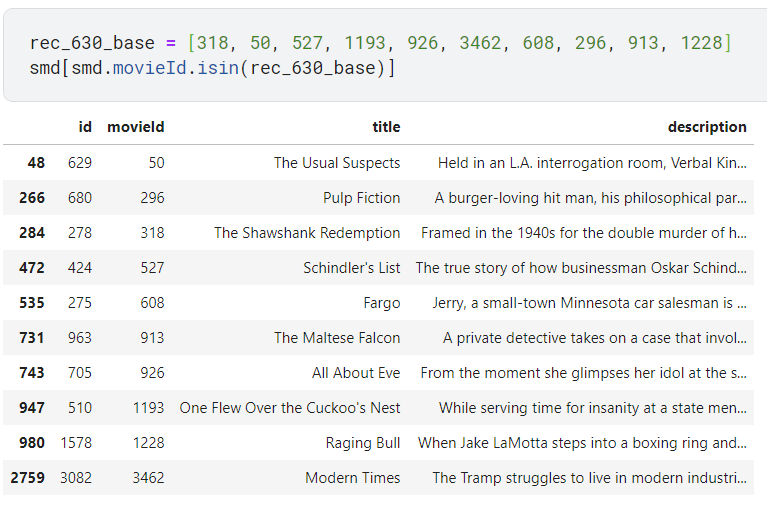

## Thử dùng các phương pháp đánh giá trên tập test

In [67]:

data.shape, test.shape

((75003, 4), (25001, 4))

In [68]:
model = CollaborativeFiltering(SVD())
model.load_data(data, test)
model.fit_predict()

RMSE: 0.9034
MAE:  0.6961


(0.9033867015073842,
 0.6960540972538086,
 0.5442594012357939,
 0.7545986822097362,
 0.6323976917683224)

So sánh với khi đánh giá model SVD() bên trên: \
(0.900186850964241, \
 0.6957369304817678,\
 0.5475501492428418,\
 0.781600109478028,\
 0.6439682101928421)
 


In [69]:
model = CollaborativeFiltering(SVDpp())
model.load_data(data, test)
model.fit_predict()

RMSE: 0.8920
MAE:  0.6846


(0.892025797499687,
 0.6845501234674327,
 0.5660084854771021,
 0.7743963441278578,
 0.6540037639643427)

So sánh với khi đánh giá model SVDpp() bên trên: \
(0.8942677172094614, \
 0.6876153915042712, \
 0.5593134964515624, \
 0.7846234388357155, \
 0.6530819526576143)
 
  -> Không có sự khác biệt lớn giữa các metrics đánh giá khi sử dụng trên tập valid với tập test

In [70]:
model = CollaborativeFiltering(BaselineOnly())
model.load_data(data, test)
model.fit_predict()

Estimating biases using als...
RMSE: 0.8995
MAE:  0.6951


(0.8994895068779108,
 0.6950960226235026,
 0.5354302055631305,
 0.7781564760325096,
 0.6343677014390197)

In [71]:
model = CollaborativeFiltering(KNNBaseline())
model.load_data(data, test)
model.fit_predict()

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9035
MAE:  0.6917


(0.9035103550736302,
 0.6916821174221489,
 0.5938660652091944,
 0.7313349014084857,
 0.6554703644053577)